In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Load your preprocessed data
data = pd.read_csv('df_join.csv')
print(data.shape)
data.head()

(144, 82)


,"Clothing and footwear, Percentage change, Previous period","Housing, Water, Electricity, Gas and Other Fuels, Percentage change, Previous period","Housing, Water, Electricity, Gas and Other Fuels",Restaurants and hotels,"Clothing and footwear, Percentage change, Previous year","Furnishings, household equipment and routine household maintenance, Percentage change, Previous year","Consumer Price Index, All items, Percentage change, Previous year","Food and non-alcoholic beverages, Percentage change, Previous year",Communication,Education,...,CPI_core,CPI_core 1-Month % Change,CPI_core 3-Month % Change,CPI_core 6-Month % Change,CPI_core 12-Month % Change,import_comm,import_comm 1-Month % Change,import_comm 3-Month % Change,import_comm 6-Month % Change,import_comm 12-Month % Change
0,-1.692365,0.151232,99.800488,97.163685,NaN,NaN,2.625709,-1.925063,100.102328,98.200945,...,220.086,0.0,-0.3,0.3,1.6,125.9,1.2,2.9,5.5,11.4
1,2.282037,-0.074967,99.725671,98.181436,NaN,NaN,2.143332,-1.469291,100.038487,98.323224,...,220.602,0.2,0.1,0.5,1.3,125.8,-0.1,1.4,3.9,11.3
2,2.102545,0.049301,99.774837,99.542993,NaN,NaN,2.313959,-0.644861,100.060433,98.510644,...,221.059,0.2,0.5,0.4,1.1,126.3,0.4,1.5,4.1,11.2
3,-0.116639,-0.071772,99.703226,99.970911,NaN,NaN,2.236447,-0.039848,100.113301,98.702634,...,221.166,0.0,0.5,0.2,0.9,127.7,1.1,1.4,4.4,11.2
4,-0.758523,0.060032,99.763080,100.486095,NaN,NaN,2.020986,0.303640,100.110308,98.748347,...,221.193,0.0,0.3,0.4,0.9,126.7,-0.8,0.7,2.1,8.5


In [3]:
# CPI is explanatory feature
X = data.drop(['CPI', 'Date'], axis=1)
y = data['CPI']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

print("Features shape:", X_imputed.shape)
print("Target shape:", y.shape)

Features shape: (144, 80)
Target shape: (144,)


In [4]:
# Feature Selection using RFE and LassoCV
lasso = LassoCV(cv=5, random_state=42)
rfe = RFE(estimator=lasso, n_features_to_select=20, step=1)
X_selected = rfe.fit_transform(X_imputed, y)
selected_features = X.columns[rfe.support_]

print("Selected features:", selected_features)
X_selected = pd.DataFrame(X_selected, columns=selected_features)

Selected features: Index(['empl', 'empl 1-Month Net Change', 'empl 3-Month Net Change',
       'empl 6-Month Net Change', 'empl 12-Month Net Change',
       'empl 1-Month % Change', 'empl 3-Month % Change',
       'empl 6-Month % Change', 'empl 12-Month % Change', 'unempl', 'CPI_core',
       'CPI_core 1-Month % Change', 'CPI_core 3-Month % Change',
       'CPI_core 6-Month % Change', 'CPI_core 12-Month % Change',
       'import_comm', 'import_comm 1-Month % Change',
       'import_comm 3-Month % Change', 'import_comm 6-Month % Change',
       'import_comm 12-Month % Change'],
      dtype='object')


In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)

Training set shape: (115, 20)
Test set shape: (29, 20)


In [6]:
# Define models and hyperparameter grids
models = {
    'ElasticNet': ElasticNet(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'SVR': SVR()
}

param_grids = {
    'ElasticNet': {'alpha': [0.1, 0.5, 1.0], 'l1_ratio': [0.1, 0.5, 0.9]},
    'RandomForest': {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 10]},
    'GradientBoosting': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5]},
    'XGBoost': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5]},
    'SVR': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto']}
}

In [7]:
# Model train and Eval
# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

results = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MSE': mse, 'R2': r2, 'Best Params': grid_search.best_params_}
    
    print(f"{name}:")
    print(f"  MSE: {mse:.4f}")
    print(f"  R2: {r2:.4f}")
    print(f"  Best Params: {grid_search.best_params_}")
    print()

ElasticNet:
  MSE: 0.5408
  R2: 0.9969
  Best Params: {'alpha': 0.1, 'l1_ratio': 0.9}

RandomForest:
  MSE: 0.6520
  R2: 0.9963
  Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}

GradientBoosting:
  MSE: 0.6908
  R2: 0.9960
  Best Params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}

XGBoost:
  MSE: 0.9273
  R2: 0.9947
  Best Params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}

SVR:
  MSE: 0.2490
  R2: 0.9986
  Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}



In [9]:
# Stacking Ensemble (Modified)

from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import KFold

# Use KFold instead of TimeSeriesSplit for the stacking ensemble
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

base_models = [(name, model) for name, model in models.items()]
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(),
    cv=kfold
)

stacking_regressor.fit(X_train_scaled, y_train)
stacking_pred = stacking_regressor.predict(X_test_scaled)
stacking_mse = mean_squared_error(y_test, stacking_pred)
stacking_r2 = r2_score(y_test, stacking_pred)

print("Stacking Ensemble:")
print(f"  MSE: {stacking_mse:.4f}")
print(f"  R2: {stacking_r2:.4f}")

Stacking Ensemble:
  MSE: 0.6999
  R2: 0.9960



Top 10 Important Features:
                          feature  importance
10                       CPI_core    0.869356
19  import_comm 12-Month % Change    0.027469
15                    import_comm    0.024814
0                            empl    0.021929
8          empl 12-Month % Change    0.011052
9                          unempl    0.010547
13      CPI_core 6-Month % Change    0.010519
4        empl 12-Month Net Change    0.009459
14     CPI_core 12-Month % Change    0.007965
18   import_comm 6-Month % Change    0.002467


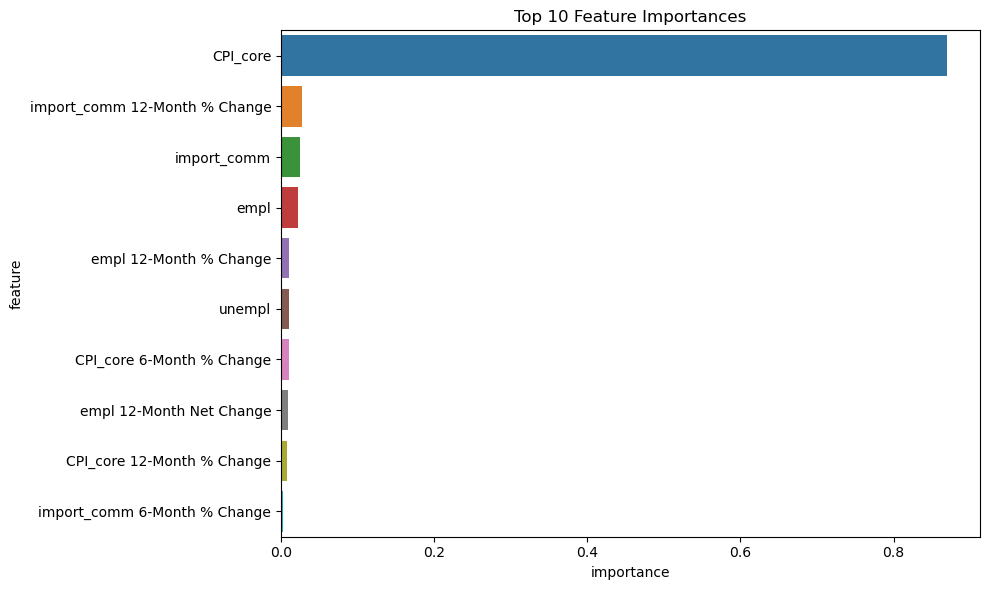

In [11]:
# Feature Importances

if 'RandomForest' in results:
    rf_model = results['RandomForest']['Best Params']
    rf_estimator = RandomForestRegressor(**rf_model)
    rf_estimator.fit(X_train_scaled, y_train)
    
    feature_importance = pd.DataFrame({
        'feature': selected_features, 
        'importance': rf_estimator.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    print("\nTop 10 Important Features:")
    print(feature_importance.head(10))

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title('Top 10 Feature Importances')
    plt.tight_layout()
    plt.show()
else:
    print("RandomForest model not found in results.")

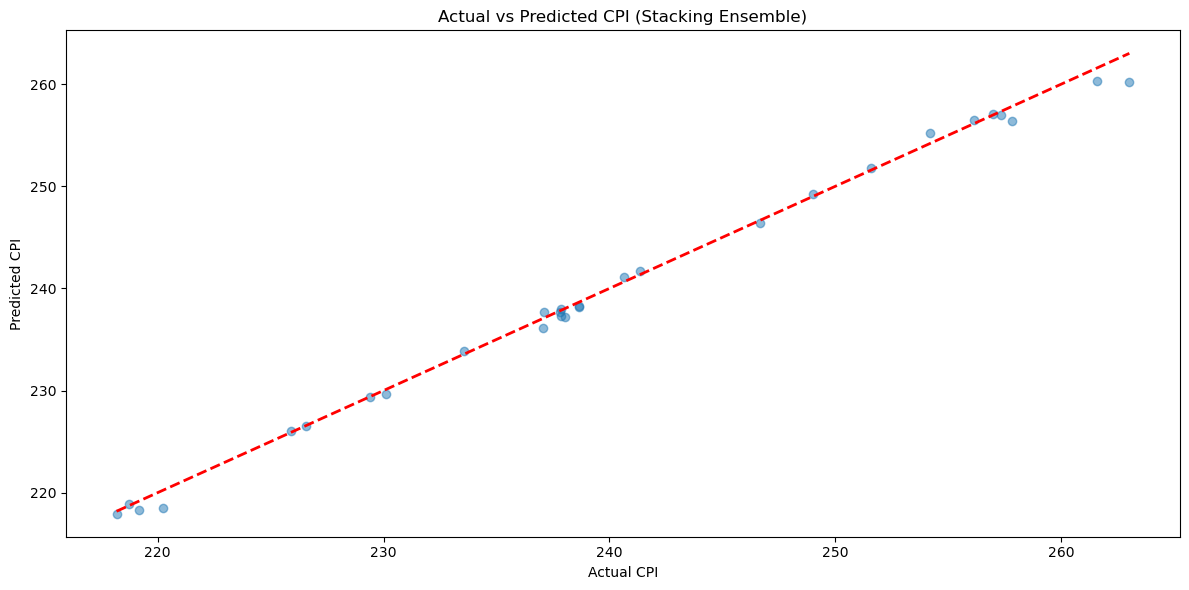

In [12]:
# VIZ Model result
plt.figure(figsize=(12, 6))
plt.scatter(y_test, stacking_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual CPI')
plt.ylabel('Predicted CPI')
plt.title('Actual vs Predicted CPI (Stacking Ensemble)')
plt.tight_layout()
plt.show()

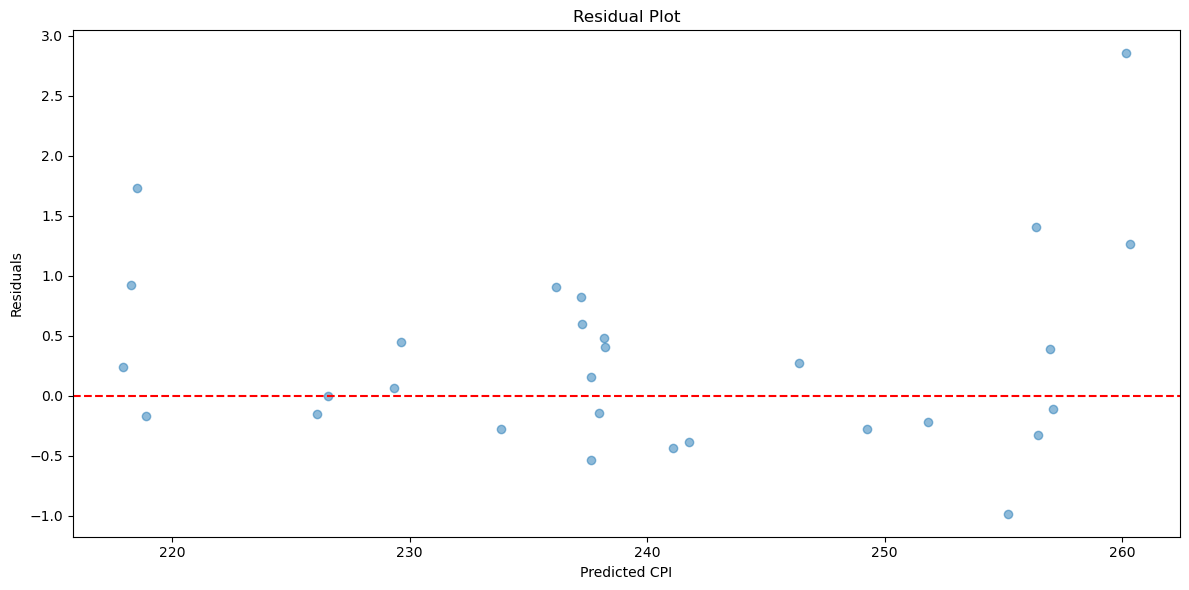

In [13]:
residuals = y_test - stacking_pred
plt.figure(figsize=(12, 6))
plt.scatter(stacking_pred, residuals, alpha=0.5)
plt.xlabel('Predicted CPI')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

In [14]:
# Save best model
import joblib

best_model_name = min(results, key=lambda x: results[x]['MSE'])
best_model = models[best_model_name]
joblib.dump(best_model, 'best_cpi_model.joblib')
print(f"Best model ({best_model_name}) saved as 'best_cpi_model.joblib'")

Best model (SVR) saved as 'best_cpi_model.joblib'
